<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Vision Transformers Using PyTorch </font></h1>


<h5>Estimated time: 90 minutes</h5>


## Introduction

In this notebook, you will learn to build a PyTorch-based hybrid Convolutional Neural Network (CNN) and Vision Transformer (ViT) for image classification. 
You'll start by using CNN layers to extract detailed features, such as edges and textures, from images. Then, you'll see how those features are passed to a Vision Transformer, which looks at the global correlations in the entire image by looking at all locations at once. Then, you will train a hybrid CNN-ViT model, and by the end of this lab, you'll also know how to monitor its performance. This approach gives you practical experience with state-of-the-art techniques in computer vision!


<h2>Objective</h2>

This notebook demonstrates how to use a custom trained PyTorch CNN model to extract feature maps and use them with a Vision Transformer (ViT) architecture to create a CNN-ViT hybrid architecture.

After completing this lab, you will be able to:
<ul>
    
1. Load the custom trained PyTorch CNN model
2. Extract feature maps from the PyTorch model
3. Prepare tokens for the Vision Transformer
4. Build the Vision Transformer encoder
5. Train and evaluate the hybrid model

</ul>


# Table of Contents
- [Model paths and download](#Model-paths-and-download)
- [Defining pre-trained CNN backbone](#Defining-pre-trained-CNN-backbone)
- [Vision Transformers](#Vision-Transformers)
    - [Patch embedding](#Patch-embedding)
    - [Multi-head self-attention (MHSA) module](#Multi-head-self-attention-(MHSA)-module)
    - [Transformer block](#Transformer-block)
    - [Vision Transformer (ViT) model](#Vision-Transformer-(ViT)-model)
- [CNN-ViT hybrid model](#CNN-ViT-hybrid-model)
- [Model training](#Model-training)
- [Model evaluation](#Model-evaluation)
- [Data preparation and loading](#Data-preparation-and-loading)
- [Model initialization and training loop](#Model-initialization-and-training-loop)
- [Plotting training and validation accuracy and loss](#Plotting-training-and-validation-accuracy-and-loss)


## Data download and extraction
Let's begin by downloading the dataset for evaluation of the models.
Here, you declare:
1. The dataset URL from where the dataset would be downloaded
2. The dataset downloading primary function, based on the `skillsnetwork` library
3. The dataset fallback downloading function, based on regular `http` downloading functions


In [1]:
import os
import skillsnetwork

data_dir = "."
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"


def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


## Package installation

Install PyTorch and python packages libraries


In [2]:
%%time
%%capture captured_output
%pip install numpy==1.26 matplotlib==3.9.2 skillsnetwork
%pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu

CPU times: user 191 ms, sys: 77.8 ms, total: 269 ms
Wall time: 1min 13s


## Library imports and setup

Import essential libraries for data manipulation, visualization, and suppresses warnings for cleaner notebook output.


In [3]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')


CPU times: user 412 ms, sys: 151 ms, total: 563 ms
Wall time: 805 ms


### PyTorch library imports

Import core PyTorch modules for model building, optimization, data loading, and functional utilities.


In [4]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
print("Imported PyTorch libraries")

Imported PyTorch libraries
CPU times: user 2.15 s, sys: 367 ms, total: 2.52 s
Wall time: 2.82 s


## Model download helper

Now, define an asynchronous function to download model files from given URLs, if they are not already present locally. 
You use `httpx` for asynchronous HTTP requests with error handling.


In [5]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

## Lab layout
- First, you download the pre-trained PyTorch based CNN model.
- Then, you define the CNN backbone. This is same as defined in the training of the pre-trained model.
- The CNN backbone reduces the input image’s spatial dimensions and expands its feature channels. You then convert this feature map into a sequence of tokens for the Vision Transformer (ViT).
- These tokens are passed into a ViT module. The ViT is applied after the CNN so it can model global relationships and context between different regions in the original image, something CNNs alone cannot do as effectively.
- You use a sequential hybrid architecture: the CNN performs local feature extraction, and the ViT, using those extracted features, performs global reasoning. This leverages the strengths of both models for improved accuracy and generalization.
- Feature reshaping is used: the CNN feature map is flattened and fed into the transformer, and positional encoding might be added to preserve spatial information.
- You train this hybrid model end-to-end, meaning both the CNN and ViT parameters are updated together to optimize classification performance.
- Throughout the process, you are able to monitor both local (CNN) and global (ViT) attention across the image, resulting in a model that is more robust and effective than using either approach alone


## Model paths and download

In the cell below, you define the file paths and URLs for the Keras and PyTorch models and download them using the `download_model` function defined above.


In [6]:
data_dir = "."

pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth"
pytorch_state_dict_name = "ai_capstone_pytorch_best_model_state_dict_downloaded.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

In [7]:
await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Model file already downloaded at: ./ai_capstone_pytorch_best_model_state_dict_downloaded.pth


## Ensuring repeatability in PyTorch

To achieve reproducible results when you train a CNN in PyTorch, you must seed every random-number generator and configures cuDNN for deterministic kernels.
* **Python & NumPy** – Many data-pipeline utilities (shuffling lists, image augmentations) rely on these random-number generators. Seeding them first removes one entire layer of randomness.
* **PyTorch CPU / GPU** – `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync.
* **cuDNN flags** – By default cuDNN picks the fastest convolution algorithm, which can vary run-to-run. Setting `deterministic=True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replacing those kernels mid-training.


In [8]:
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)            
    torch.cuda.manual_seed_all(seed)   

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark     = False 


In [9]:
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - main process is now deterministic.")

Global seed set to 7331 - main process is now deterministic.


## Defining pre-trained CNN backbone

In this cell, you will create and implement a **ConvNet** class. This class serves as the convolutional backbone for the hybrid CNN-ViT architecture. 
The design of this class will be **same as the training architecture**, with six progressive convolutional blocks.

- **`forward_features()`**: Returns the raw convolutional feature map (B, 1024, H, W) for use by the **ViT component**

- **Role in hybrid architecture**: In the hybrid model, this CNN serves as a **local feature extractor**, capturing low-level patterns, edges, and textures before passing the feature-rich representation to the Vision Transformer for global context modeling. The 1024-channel output provides a rich semantic representation that the ViT can process as a sequence of tokens.


In [10]:
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model for extracting the` feature map
    '''
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024)
        )

    def forward_features(self, x):
        return self.features(x)      # (B,1024,H,W)


# Vision Transformers


### Patch embedding
 The **PatchEmbed** class implements the **interface** between the CNN feature extractor and the Vision Transformer, converting spatial feature maps into a sequence of tokens suitable for self-attention processing.

Unlike traditional ViT implementations that divide raw images into fixed-size patches, this hybrid approach operates on CNN feature maps. The implementation uses a **1×1 convolution** as a learned linear projection to transform the 1024-dimensional CNN features into the transformer's embedding dimension (default 768).

The transformation process involves three key steps:
1. **Channel projection**: `nn.Conv2d(in_ch, embed_dim, kernel_size=1)` reduces or expands the channel dimension from 1024 to the preferred embedding size
2. **Spatial flattening**: `.flatten(2)` collapses the height and width dimensions (H×W) into a single sequence dimension
3. **Tensor reshaping**: `.transpose(1,2)` reorders dimensions from (B, D, L) to (B, L, D) where L=H×W represents the sequence length

**Integration with hybrid architecture**

In the context of the hybrid model, this patch embedding serves as the **bridge** between local CNN features and global transformer processing. Since the CNN has already extracted meaningful local patterns, the patch embedding focuses on format conversion rather than feature extraction. This design is more **efficient** than traditional ViT patch embedding since the CNN has already performed the heavy lifting of feature extraction from raw pixels.

The **output tensor** (B, L, D) represents a batch of sequences where each sequence contains L tokens (corresponding to spatial locations in the feature map) with D-dimensional embeddings ready for transformer processing.


In [11]:
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

## Multi-head self-attention (MHSA) module

The **MHSA** class implements the self-attention mechanism that enables the Vision Transformer to model long-range dependencies and global context across all spatial locations in the feature map.

The implementation follows the scaled dot-product attention formula: **Attention(Q,K,V) = softmax(QK^T/√d)V**, where Q, K, and V represent query, key, and value matrices, respectively. The scaling factor 1/sqrt(d) prevents the dot products from becoming too large, which would push the softmax function into regions with extremely small gradients.

The multi-head mechanism splits the embedding dimension across multiple attention heads, allowing the model to attend to different types of relationships simultaneously. 

### Key implementation details:

- **Unified QKV projection**: A single linear layer `nn.Linear(dim, dim*3)` generates Q, K, and V matrices efficiently, reducing memory overhead compared to separate projections
- **Head reshaping**: The tensor is reshaped from (B, N, D) to (B, heads, N, d) where d = D/heads, enabling parallel processing across heads
- **Attention computation**: Matrix multiplication `torch.matmul(q, k.transpose(-2, -1))` computes attention scores, followed by scaling and softmax normalization
- **Dropout regularization**: Two dropout layers prevent overfitting - one on attention weights and one on the final output


Unlike CNNs, which have limited receptive fields, self-attention allows every token to interact directly with every other token in a single operation. This enables the model to **capture long-range spatial dependencies** that might be missed by purely convolutional approaches. 

#### In the hybrid architecture, this global modeling complements the local feature extraction performed by the CNN backbone.

The attention weights provide interpretability, showing which spatial locations the model focuses on when making predictions. This component is valuable for both performance and explainability.


In [12]:
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

## Transformer block
This code defines a building block used in modern deep learning models, especially in Vision Transformers. The class is called TransformerBlock, and it is responsible for helping the model “pay attention” to the most important parts of its input and improve the final predictions.

Let’s break down what happens inside:

**Layer normalization (nn.LayerNorm):** This helps stabilize and speed up training by normalizing each row of the input data, which is useful before applying attention or a neural network layer.

**Attention layer (MHSA):** This is the “Multi-Head Self Attention” block. It enables the model to look at all positions in the sequence (or image patches) at once, figuring out which ones are most important for each output. It’s like giving the model the power to focus on the key parts of an image or sentence.

**MLP (nn.Sequential):** This is a **Multi-Layer Perceptron** or a mini neural network, made up of linear (fully connected) layers, a special activation (GELU), and dropout for regularization. This MLP has:
- One linear layer that expands the input dimension by mlp_ratio (for example, 4× wider).
- A GELU activation function (a nonlinear operation, similar to ReLU).
- Dropout for regularization (helps prevent overfitting).
- Another linear layer that shrinks the data back to the original dimension.
- Another dropout layer.
Here, MLP is designed to help the model learn better representations by combining and transforming the information after the attention step.

**Skip/Residual connections (x + ...):** These connections support effective and stable training for deep neural networks by keeping pathways open for both forward information flow and backward gradient flow, making deep architectures such as transformers possible and practical. In transformers, skip connections are placed around both the attention and feedforward (MLP) sub-layers in each block. This stabilizes training of these very deep, stackable models, improves convergence speed, and lets them scale to larger datasets and more complex tasks.

In summary, this block helps models understand relationships in their input data, making them more powerful for tasks such as image and language understanding!


In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Vision Transformer (ViT) model

The **ViT** class represents the complete Vision Transformer implementation, including patch embedding, positional encoding, transformer blocks, and a classification head for global context modeling.

The implementation uses a learnable **Classification [CLS] token**:
- **Initialization**: `nn.Parameter(torch.zeros(1, 1, embed_dim))` creates a learnable token initialized to zeros
- **Expansion**: `self.cls.expand(B, -1, -1)` replicates the token across the batch dimension
- **Prepending**: `torch.cat((cls, x), 1)` concatenates the CLS token to the beginning of the sequence
- **Classification**: Only the CLS token representation is used for final classification

This allows the CLS token to aggregate information from all spatial locations through self-attention, creating a global representation suitable for classification.

`nn.Parameter(torch.randn(1, max_tokens, embed_dim))` creates a large positional embedding matrix
and `self.pos[:, :L+1]` dynamically slices the positional embeddings to match the actual sequence length. Together, these create a **dynamic positional encoding** system for the hybrid architecture where the CNN feature map size can vary based on input image dimensions.


**`depth`** defines the number of transformerBlocks to be used in the transformer encoder
### Classification head design

The final classification pipeline includes:
1. **Final normalization**: `self.norm(x)` applies LayerNorm to the final transformer output
2. **CLS token extraction**: `[:, 0]` selects only the CLS token representation
3. **Linear classification**: `self.head` maps the CLS representation to class logits

The model's ability to handle variable sequence lengths makes it robust to different input sizes and CNN architectures, providing flexibility in deployment scenarios.


In [14]:
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

## CNN-ViT hybrid model

The **CNN_ViT_Hybrid** class represents the hybrid architecture, integrating the CNN backbone with the Vision Transformer to create a unified model that leverages both local and global feature processing capabilities.
In this hybrid model, the pre-trained CNN layers can be frozen while fine-tuning the Vi and allows for **efficient attention** to operate on semantically rich CNN features rather than raw pixels
Thus, this hybrid approach combines the excellent capabilities of CNN to capture local patterns efficiently with ViTs' global context modeling, while keeping the level of complexity low.

The forward pass implements a **two-stage forward pass pipeline**:
1. **Local feature extraction**: `self.cnn.forward_features(x)` processes the input image through the CNN backbone, extracting hierarchical local features and reducing spatial resolution while increasing semantic depth.
2. **Global context modeling**: `self.vit(features)` takes the CNN feature map and processes it through the Vision Transformer for global reasoning and classification.

Despite the modular design, the entire hybrid model remains **fully differentiable**, enabling end-to-end training where gradients could flow from the classification loss back through both the ViT and CNN components. This allows the CNN to learn features that are optimally suited for the downstream transformer processing, creating a synergistic relationship between the two architectures.


In [15]:
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

# Model training

The **train** function implements a comprehensive training loop for one epoch, handling forward propagation, loss computation, backpropagation, and metric tracking in a memory-efficient manner.

**Training mode**
The function begins with `model.train()`, which configures the model for training by enabling dropout layers and gradient computation

**Batch processing pipeline**
Each training iteration follows a standard deep learning pipeline:

1. **Data transfer**: `x, y = x.to(device), y.to(device)` moves input data and labels to the appropriate device (CPU/GPU)
2. **Gradient reset**: `optimizer.zero_grad()` clears gradients from the previous iteration to prevent accumulation
3. **Forward pass**: `out = model(x)` computes predictions through the hybrid CNN-ViT architecture
4. **Loss computation**: `loss = criterion(out, y)` calculates cross-entropy loss between predictions and ground truth
5. **Backpropagation**: `loss.backward()` computes gradients via automatic differentiation
6. **Parameter update**: `optimizer.step()` updates model parameters using the computed gradients

**Metric accumulation**: The function tracks two key metrics:
- **Weighted loss**: `loss.item() * x.size(0)` accumulates loss weighted by batch size for accurate averaging
- **Correct predictions**: `(out.argmax(1) == y).sum().item()` counts correct predictions using argmax for multi-class classification


In [16]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    loss_sum, correct = 0, 0
    for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Training  ")):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Model evaluation
Here, you will evaluate the model, implementing inference without gradient computation to optimize memory usage and computational speed.

Two fundamental differences between using the model for evaluation and testing versus training are:
- **`torch.no_grad()`**:  Disables gradient computation and accelerate inference
- **`model.eval()`**: Switches the model to evaluation mode, ensures deterministic outputs

The **evaluation loop** mirrors the training loop structure but omits gradient-related operations.

This function **integrates with the training pipeline**, providing regular validation checks that help monitor model progress, detect overfitting, and make informed decisions about training continuation, learning rate adjustments, and model selection. The consistent interface with the training function enables easy integration into automated training workflows.


In [17]:
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

## Data preparation and loading

Here, you implement data preparation for the entire data pipeline, from raw image loading to batched tensor delivery.

You define the key training hyperparameters:
- **Image size (64×64)**: Chosen for computational efficiency while maintaining sufficient resolution for feature extraction
- **Batch size (128)**: Balances memory usage with gradient stability and training speed
- **learning rate (0.001)**: A conservative number for learning
- **number of classes**: Total number of classes to be classified by the model


In [18]:
dataset_path = os.path.join(data_dir, "images_dataSAT")

img_size = 64
batch_size = 32
lr = 0.001
num_cls  = 2


### Training data transformations
The **training transform** pipeline implements several **augmentation techniques** including Random Rotation, Random Horizontal Flip, Random Affine with Shear and normalization.


## Task: Create `train_transform` transforms for the training dataset
- Use the following parameters:
    - Size: `img_size x img_size`
    - `RandomRotation`: 40
    - `RandomHorizontalFlip`
    - `RandomAffine(0, shear=0.2)`
    - `Normalization` values: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [21]:
## You can use this cell to type the code to complete the task.
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

Double-click **here** for the solution.
<!--
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
-->


### Validation data transformations
The **validation transform** is minimal for **deterministic preprocessing** to ensure reproducible validation results


## Task: Create `val_transform` transforms for the validation dataset
- Use the following parameters:
    - Size: `img_size x img_size`
    - `Normalization` values: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [22]:
## You can use this cell to type the code to complete the task.
val_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

Double-click **here** for the solution.
<!--
val_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
-->


### The DataLoader

The DataLoader setup is optimized for training:
- **Shuffling**: Training data is shuffled to prevent batch-level patterns
- **No Validation Shuffling**: Validation order is consistent for reproducible results
- **`batch_size`**: Efficient tensor batching for GPU utilization

You begin by splitting the dataset into `training` and `validation` data using `random_split` feature. Here, you define **80%** (0.8 fraction) of the total dataset for training and rest for validation.

Next, you apply the `train_transform` to `train_dataset` and `val_transform` to `val_dataset` to make the dataset ready for DataLoader


In [23]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

## Task: Create the Dataloader `train_loader` and `val_loader` using `train_dataset` and `val_dataset`
- Use the following parameters:
    - `batch_size=batch_size`
    - for `train_loader`: `shuffle=True`
    - for `val_loader`: `shuffle=False`


In [24]:
## You can use this cell to type the code to complete the task.
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                       )

Double-click **here** for the solution.
<!--
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                       )
-->


## Model initialization and training loop

This cell orchestrates the complete training pipeline, from model instantiation through iterative training and validation, implementing comprehensive monitoring and logging for effective model development.

- **CUDA detection**: `torch.cuda.is_available()` checks for GPU availability

The hybrid model is instantiated with carefully chosen hyperparameters:
- **Number of classes**: `num_classes=2` configured for the specific dataset
- **Default architecture**: Uses ViT configuration (768 embedding dim, 1  transformer layer, 1 heads)

### Transfer learning integration

The commented line demonstrates transfer learning capability:
- **Pre-trained weights**: Option to load pre-trained CNN backbone weights
- **Flexible loading**: `strict=False` allows partial weight loading

**Optimizer**: The training uses the `adam` optimizer.

The training loop collects the **training and validation metrics** to track training performance and monitor generalization of the model.

### Training loop architecture

Each epoch follows a structured pipeline:
1. **Timing**: `time.time()` tracks epoch duration for performance monitoring
2. **Training phase**: Calls the training function with appropriate parameters
3. **Validation phase**: Evaluates model on validation set
4. **Logging**: Comprehensive output showing all metrics and timing
5. **Storage**: Appends metrics to tracking lists for later analysis

In this training cell, you create a robust, monitored, and efficient training pipeline that provides comprehensive insights into model performance while maintaining computational efficiency and enabling easy debugging and optimization.


In [25]:
device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")


epochs     = 5
attn_heads = 6
depth      = 3
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_state_dict.pth"

model     = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)


# ------------------------------------------------------------------ #
# loading pre-trained CNN weights
model.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------ #


criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=lr)


best_loss = float('inf')
tr_loss_all = []
te_loss_all = []
tr_acc_all = []
te_acc_all = []

training_time = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all.append(tr_loss)
    te_loss_all.append(te_loss)
    tr_acc_all.append(tr_acc)
    te_acc_all.append(te_acc)
    training_time.append(time.time() - start_time)
    
    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model.state_dict(), model_dict_name)

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")


Training the model on cpu
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768

Epoch 01/05 started at 20251109_135421 (UTC)


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.91it/s]


Epoch 01 | train loss 0.3249 acc 0.9354 | val loss 0.0399 acc 0.9858 | in  405.38s
Current loss (0.0399) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251109_140109 (UTC)


Validation: 100%|██████████| 38/38 [00:22<00:00,  1.71it/s]


Epoch 02 | train loss 0.1452 acc 0.9565 | val loss 0.0443 acc 0.9900 | in  390.34s

Epoch 03/05 started at 20251109_140739 (UTC)


Validation: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s]


Epoch 03 | train loss 0.0567 acc 0.9817 | val loss 0.0296 acc 0.9917 | in  393.53s
Current loss (0.0296) lower than previous best loss (0.0399), Saving current model state

Epoch 04/05 started at 20251109_141415 (UTC)


Validation: 100%|██████████| 38/38 [00:23<00:00,  1.65it/s]


Epoch 04 | train loss 0.0634 acc 0.9815 | val loss 0.0251 acc 0.9925 | in  392.27s
Current loss (0.0251) lower than previous best loss (0.0296), Saving current model state

Epoch 05/05 started at 20251109_142049 (UTC)


Validation: 100%|██████████| 38/38 [00:20<00:00,  1.82it/s]

Epoch 05 | train loss 0.0473 acc 0.9862 | val loss 0.0272 acc 0.9925 | in  394.10s
epochs:5 | batch:32 | attn_heads:6 | depth:3 | embed_dim:768


### Hyperparameter cheatsheet (depth based)

The Depth of the transformer blocks signify the number of transformer blocks stacked in the model. This is one of the most important features which differentiates a ViT from CNN.

This table proides a basic overview on **how depth affects** other hyperparameters and model performance.

|  **Depth** | **Attention heads** | **Dataset Size** |  **Performance** | **learning rate** | **Feature Complexity** | **Learning Focus** |
|:---:|:---:|---|:---:|---|:---|:---:|
| **3** | 6 | size < 1000 | Underfitting - too shallow |0.001 (Shallow: can handle higher learning rates) | Low-level features | Edges, textures, basic patterns |
| **6** | 6 | size <1000 | Good for simple tasks |0.001 (Shallow: can handle higher learning rates) | Mid-level features | Shapes, object parts, spatial relationships |
| **12** | 12 | 1000 < size < 10000 | Standard choice - good balance | 0.0005 (Medium: moderate learning rate) | High-level features | Objects, semantic concepts, global context |
| **18** | 12 | 10000 < size < 100000 | High performance on complex tasks | 0.0003 (Deep: lower learning rate for stability) | High-level features | Objects, semantic concepts, global context |
| **24** | 16 | 100000 < size | Diminishing returns, overfitting risk | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |
| **36** | 16 | 100000 < size | Likely overkill for most tasks | 0.0001 (Very deep: very small learning rate) | High-level features | Objects, semantic concepts, global context |


### Task: Design and train a CNN-ViT hybrid model `model_test` with the following hyperparameters:
- `epochs=5`
- `attn heads=12`
- `transformer block depth = 12`
- `embed_dim=768`

Save the `accuracy` and `loss` metrics in
- `tr_loss_all_test` for training loss
- `te_loss_all_test` for validation/testing loss
- `tr_acc_all_test` for training accuracy
- `te_acc_all_test` for validation/testing accuracy

Save the training times in `training_time_test`

Save the best model as **`ai_capstone_pytorch_vit_model_test_state_dict.pth`**


In [26]:
## Please use the space below to write your answer


device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

epochs     = 5
attn_heads = 12
depth      = 12
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_test_state_dict.pth"

model_test = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)

# ------------------------------------------------------------------ #
# loading pre-trained CNN weights
model_test.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------ #

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_test.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all_test = []
te_loss_all_test = []
tr_acc_all_test = []
te_acc_all_test = []
training_time_test = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model_test, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model_test, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all_test.append(tr_loss)
    te_loss_all_test.append(te_loss)
    tr_acc_all_test.append(tr_acc)
    te_acc_all_test.append(te_acc)
    training_time_test.append(time.time() - start_time)

    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model_test.state_dict(), model_dict_name)


Training the model on cpu
epochs:5 | batch:32 | attn_heads:12 | depth:12 | embed_dim:768

Epoch 01/05 started at 20251109_142724 (UTC)


Validation: 100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


Epoch 01 | train loss 0.6457 acc 0.7681 | val loss 0.9057 acc 0.4992 | in  698.81s
Current loss (0.9057) lower than previous best loss (inf), Saving current model state

Epoch 02/05 started at 20251109_143906 (UTC)


Validation: 100%|██████████| 38/38 [00:34<00:00,  1.09it/s]


Epoch 02 | train loss 0.3861 acc 0.8458 | val loss 0.2636 acc 0.9300 | in  684.67s
Current loss (0.2636) lower than previous best loss (0.9057), Saving current model state

Epoch 03/05 started at 20251109_145033 (UTC)


Validation: 100%|██████████| 38/38 [00:34<00:00,  1.11it/s]


Epoch 03 | train loss 0.2798 acc 0.8877 | val loss 0.6979 acc 0.5400 | in  706.26s

Epoch 04/05 started at 20251109_150219 (UTC)


Validation: 100%|██████████| 38/38 [00:35<00:00,  1.07it/s]


Epoch 04 | train loss 0.6673 acc 0.6335 | val loss 0.5839 acc 0.7200 | in  741.80s

Epoch 05/05 started at 20251109_151441 (UTC)


Validation: 100%|██████████| 38/38 [00:35<00:00,  1.06it/s]

Epoch 05 | train loss 0.6064 acc 0.7102 | val loss 0.5774 acc 0.7292 | in  787.66s


Double-click **here** for the solution.
<!--
## Please use the space below to write your answer

device   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training the model on {device}")

epochs     = 5
attn_heads = 12
depth      = 12
embed_dim  = 768

print(f"epochs:{epochs} | batch:{batch_size} | attn_heads:{attn_heads} | depth:{depth} | embed_dim:{embed_dim}")

model_dict_name = f"ai_capstone_pytorch_vit_model_test_state_dict.pth"

model_test = CNN_ViT_Hybrid(num_classes=num_cls,
                            heads=attn_heads,
                            depth=depth,
                            embed_dim=embed_dim
                           ).to(device)

# ------------------------------------------------------------------ #
# loading pre-trained CNN weights
model_test.cnn.load_state_dict(torch.load(pytorch_state_dict_path), strict=False)
# ------------------------------------------------------------------ #

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_test.parameters(), lr=lr)

best_loss = float('inf')
tr_loss_all_test = []
te_loss_all_test = []
tr_acc_all_test = []
te_acc_all_test = []
training_time_test = []
for epoch in range(1, epochs+1):
    start_time = time.time()
    print(f"\nEpoch {epoch:02d}/{epochs:02d} started at {present_time()} (UTC)")
    tr_loss,tr_acc = train(model_test, train_loader, optimizer, criterion, device)
    te_loss,te_acc = evaluate(model_test, val_loader, criterion, device)
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {te_loss:.4f} acc {te_acc:.4f} |"
          f" in  {time.time()-start_time:.02f}s"
        )
    tr_loss_all_test.append(tr_loss)
    te_loss_all_test.append(te_loss)
    tr_acc_all_test.append(tr_acc)
    te_acc_all_test.append(te_acc)
    training_time_test.append(time.time() - start_time)

    # Save the best model
    avg_te_loss = te_loss
    if avg_te_loss < best_loss:
        print(f"Current loss ({avg_te_loss:.04f}) lower than previous best loss ({ best_loss:.04f}), Saving current model state")
        best_loss = avg_te_loss
        torch.save(model_test.state_dict(), model_dict_name)

-->


## Plotting training and validation accuracy and loss

This visualization cell creates comprehensive learning curves that provide crucial insights into model training dynamics, performance trends, and potential issues such as overfitting or underfitting.

The implementation creates two separate plots for different aspects of training analysis:
- **Accuracy plot**: Shows classification performance trends over epochs
- **Loss plot**: Reveals optimization dynamics and convergence behavior


These plots enable several important diagnostic assessments:
- **Overfitting detection**: Widening gap between training and validation metrics
- **Underfitting identification**: Both metrics plateau at suboptimal levels
- **Training completion**: Convergence indicates when to stop training
- **Hyperparameter evaluation**: Curves help assess learning rate, regularization effectiveness

These learning curves serve as essential tools for understanding model behavior, diagnosing training issues, and making informed decisions about hyperparameter adjustments, training duration, and model architecture modifications.


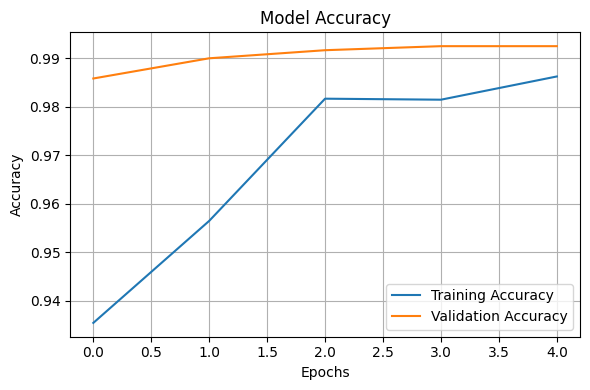

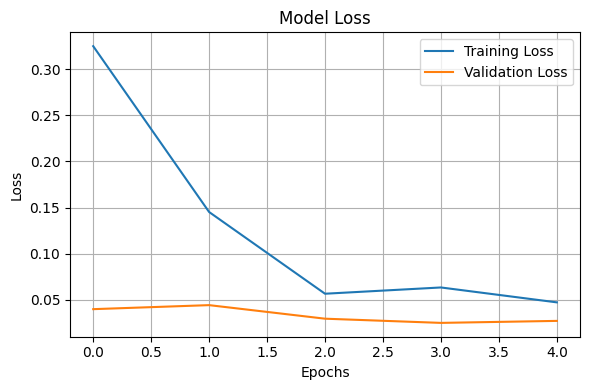

In [27]:
fig_w, fig_h = 6,4
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(tr_acc_all, label='Training Accuracy')
axs.plot(te_acc_all, label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(tr_loss_all, label='Training Loss')
axs.plot(te_loss_all, label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

## Task: Compare the performance of `model` with `model_test` by plotting the validation loss for `model` and `model_test` ViTs


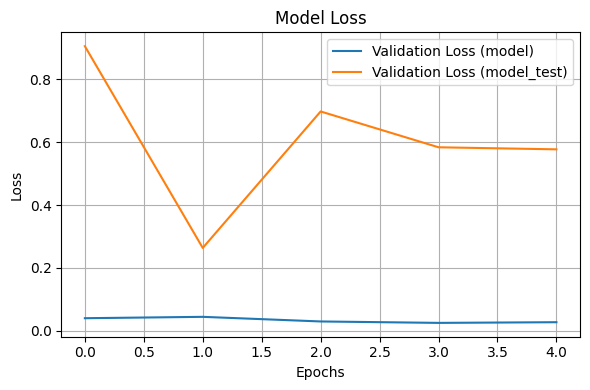

In [28]:
## Please use the space below to write your answer
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(te_loss_all, label='Validation Loss (model)')
axs.plot(te_loss_all_test, label='Validation Loss (model_test)')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

Double-click **here** for the solution.
<!--

fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(te_loss_all, label='Validation Loss (model)')
axs.plot(te_loss_all_test, label='Validation Loss (model_test)')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

-->


## Task: Compare the training times of `model` with `model_test` by plotting the training time for each


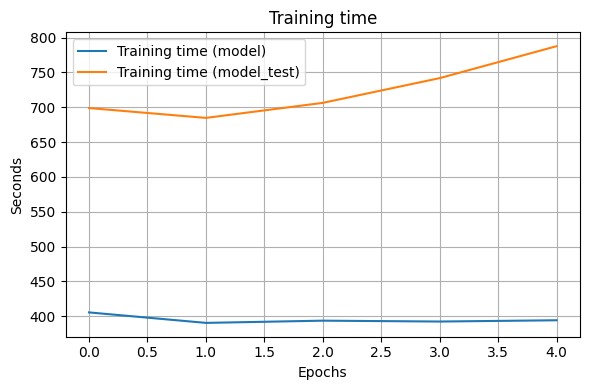

In [29]:
## Please use the space below to write your answer
fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(training_time, label='Training time (model)')
axs.plot(training_time_test, label='Training time (model_test)')
axs.set_title('Training time')
axs.set_xlabel('Epochs')
axs.set_ylabel('Seconds')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


Double-click **here** for the solution.
<!--

fig, axs = plt.subplots( figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(training_time, label='Training time (model)')
axs.plot(training_time_test, label='Training time (model_test)')
axs.set_title('Training time')
axs.set_xlabel('Epochs')
axs.set_ylabel('Seconds')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()

-->


## Save and download the trained model weights

You have successfully trained the ViT model for the classification of agricultural land from satellite imagery. 
In this lab, in the interest of time, you have trained the model for 3-5 epochs. However, usually you train the model for around 15-20 epochs, depending on the quality of training data and model metrics for the validation. 

For your convenience, I have saved a model state dict for the model trained over 20 epochs **[here](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rFBrDlu1NNcAzir5Uww8eg/pytorch-cnn-vit-ai-capstone-model-state-dict.pth)**. You can download that for evaluation and further labs on your local machine from **[this link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rFBrDlu1NNcAzir5Uww8eg/pytorch-cnn-vit-ai-capstone-model-state-dict.pth)**.


Otherwise, you have also saved the model state dictionary for the best model using the `torch.save` function during training in this lab.

You can also download the model state dict for the model that you have just trained for use in the subsequent labs.

This is the PyTorch AI model state that can now be used for inferring unclassified images. 

- You can download the trained model file: `ai_capstone_pytorch_vit_model_state_dict.pth` from the left pane and save it on your local computer. 
- You can download this model by "right-clicking" on the file and then clicking "Download".
- This model could be used in other labs of this AI capstone course, instead of the model provided at the above link


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed notebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion

Congratulations! You've successfully built a PyTorch-based hybrid Convolutional Neural Network (CNN) and Vision Transformer (ViT) for image classification.


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.



<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-24  | 1.0  | Aman  |  Created the lab |
| 2025-07-24  | 1.1  | Leah Hanson  | QA reviewed for IBM style guide adherence |

-->


© Copyright IBM Corporation. All rights reserved.
